In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

Просмотрим содержимое датафреймов

In [2]:
try:
    geo_0 = pd.read_csv(r"C:\Users\User\Geo\geo_data_0.csv")
    geo_1 = pd.read_csv(r"C:\Users\User\Geo\geo_data_1.csv")
    geo_2 = pd.read_csv(r"C:\Users\User\Geo\geo_data_2.csv")
except:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def geo_info(geo):

    print(geo.info())
    print(geo.describe())
    print(geo.isnull().sum())
    print('К-во дубликатов', geo.duplicated().sum())

geo_info(geo_0)
geo_info(geo_1)
geo_info(geo_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.3437

Пропусков в таблицах нет. Дубликатов нет. Все названия столбцов в едином формате. Данные также однообразны.

Заметил также столбец с айдишниками, вряд ли он окается полезен для исследования. Дропну его.

In [4]:
geo_0 = geo_0.drop(['id'], axis=1)
geo_1 = geo_1.drop(['id'], axis=1)
geo_2 = geo_2.drop(['id'], axis=1)
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


Построим матрицы корелляции по регионам

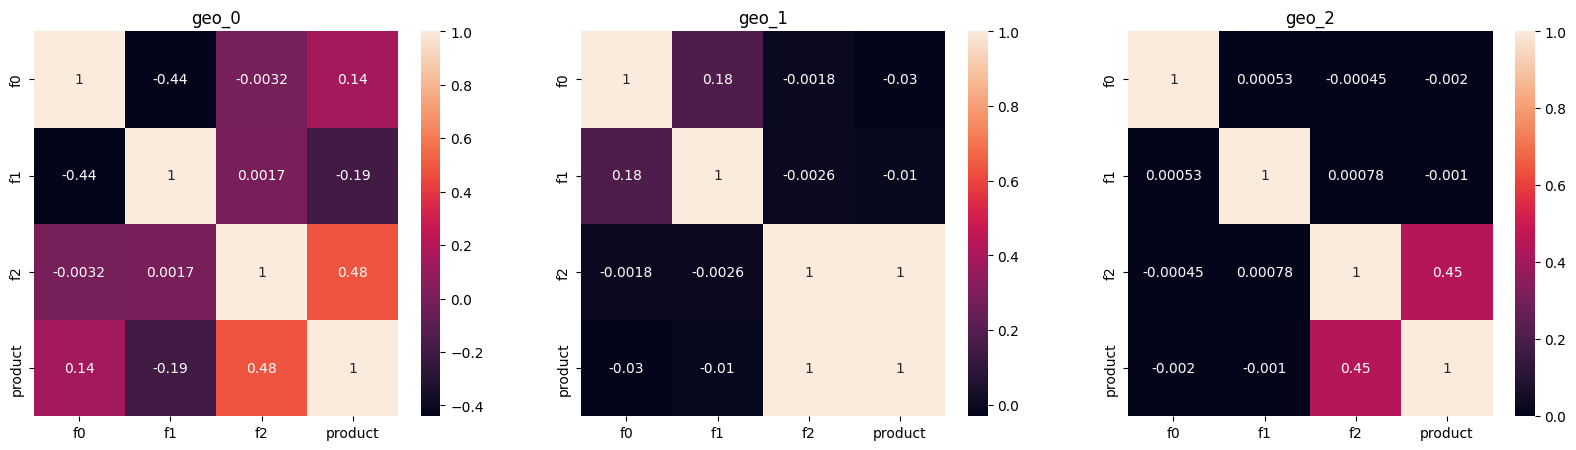

In [5]:
def geo_heatmap(geo_0, geo_1, geo_2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    sns.heatmap(geo_0.corr(), annot=True, ax=ax1)
    ax1.set_title('geo_0')
    sns.heatmap(geo_1.corr(), annot=True, ax=ax2)
    ax2.set_title('geo_1')
    sns.heatmap(geo_2.corr(), annot=True, ax=ax3)
    ax3.set_title('geo_2')
    plt.show()

geo_heatmap(geo_0, geo_1, geo_2)

Предварительный вывод:<p>
1 регион - заметна средняя корелляция между объемом запаса в скважине и третьим признаком, очень слабая корелляция между объемом и оставшимися двумя признаками (Положительная - для первого, отрицательная - для второго). Средняя отрицательная корелляция между первым и вторым признаками. <p>
2 регион - заметна очень сильная корелляция между объемом запаса в скважине и третьим признаком <p>
3 регион - заметна средняя корелляция между объемом запаса в скважине и третьим признаком <p>
<p>
Интересно то, что только в первом регионе наблюдается (в целом, заметная) корелляция между запасом в скважине и каждым из признаков.

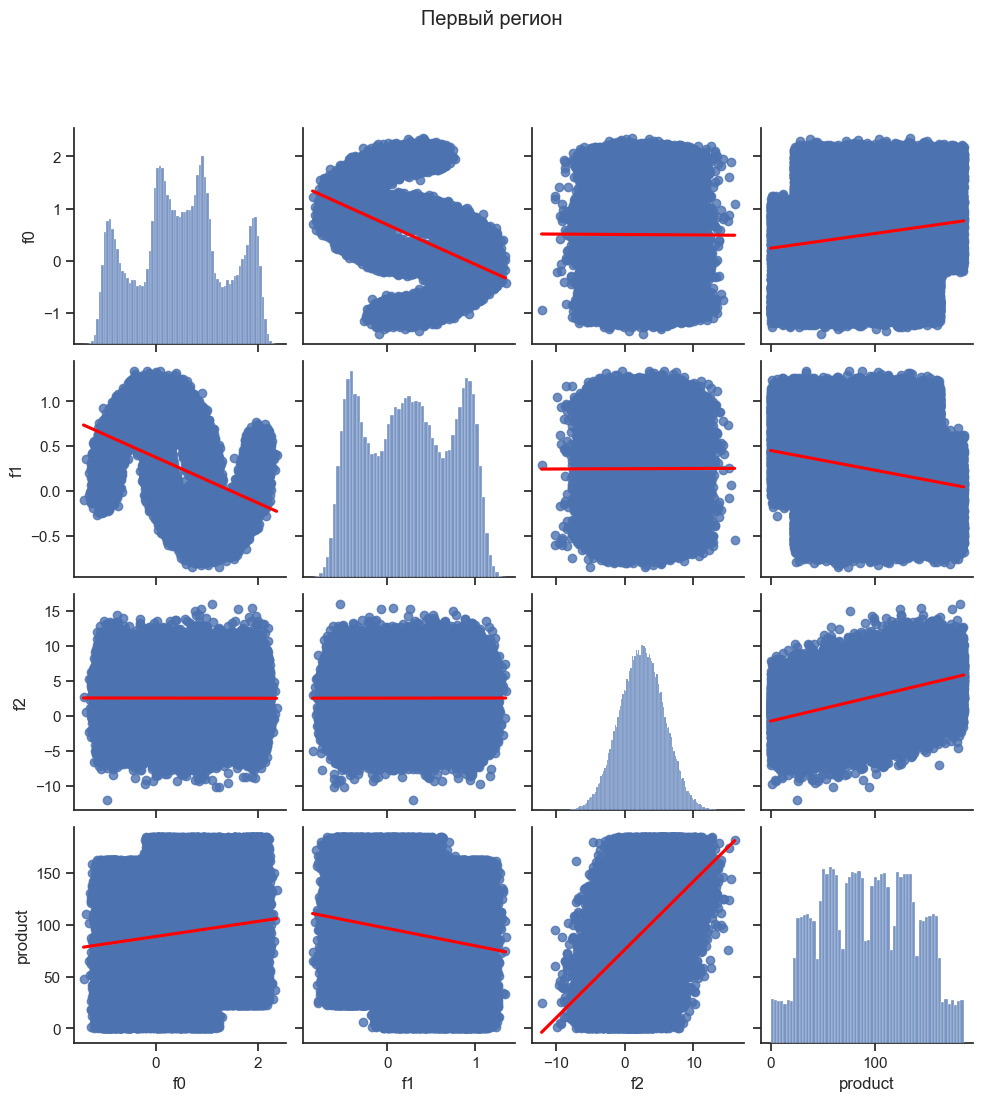

In [6]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(geo_0, kind="reg", plot_kws={'line_kws':{'color':'red'}})
g.fig.suptitle('Первый регион', y=1.1)
plt.show()

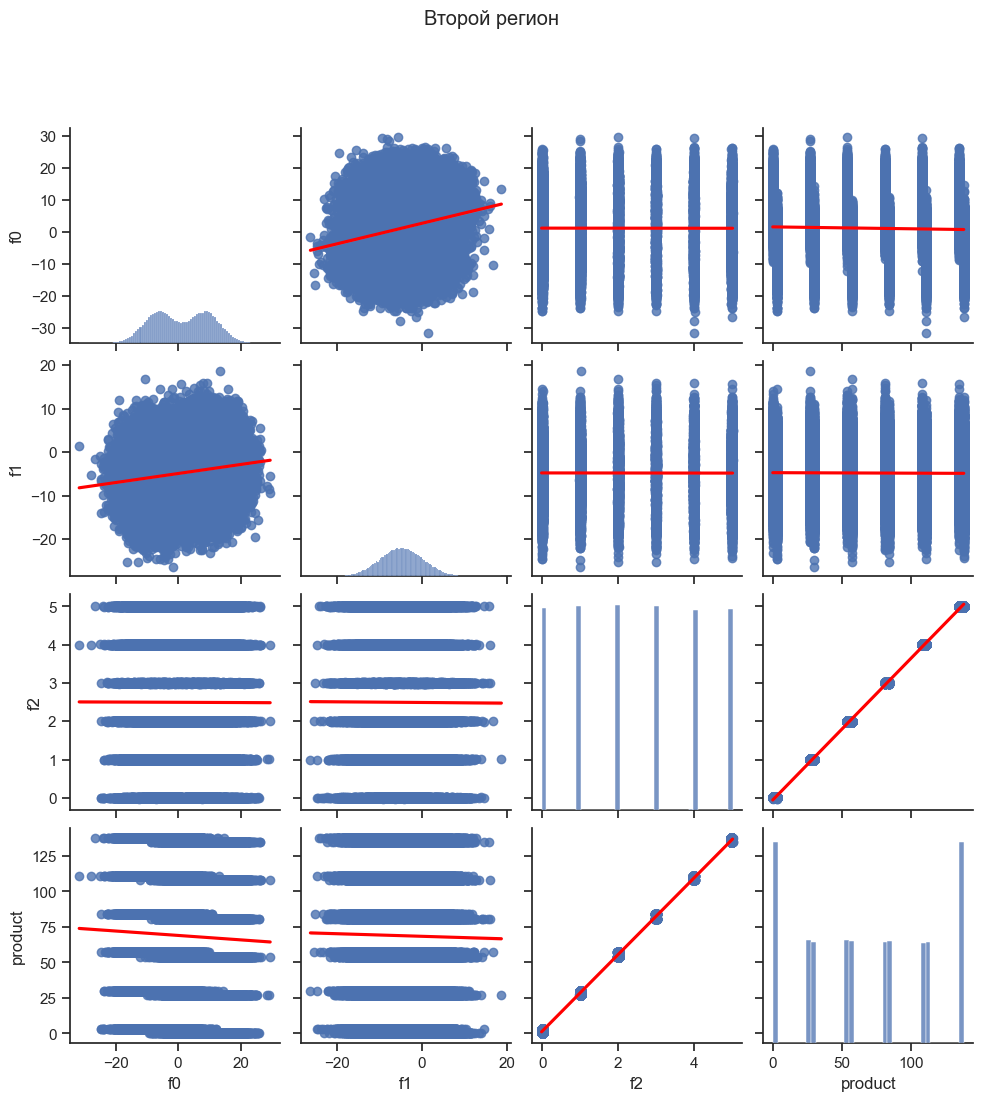

In [7]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(geo_1, kind="reg", plot_kws={'line_kws':{'color':'red'}})
g.fig.suptitle('Второй регион', y=1.1)
plt.show()

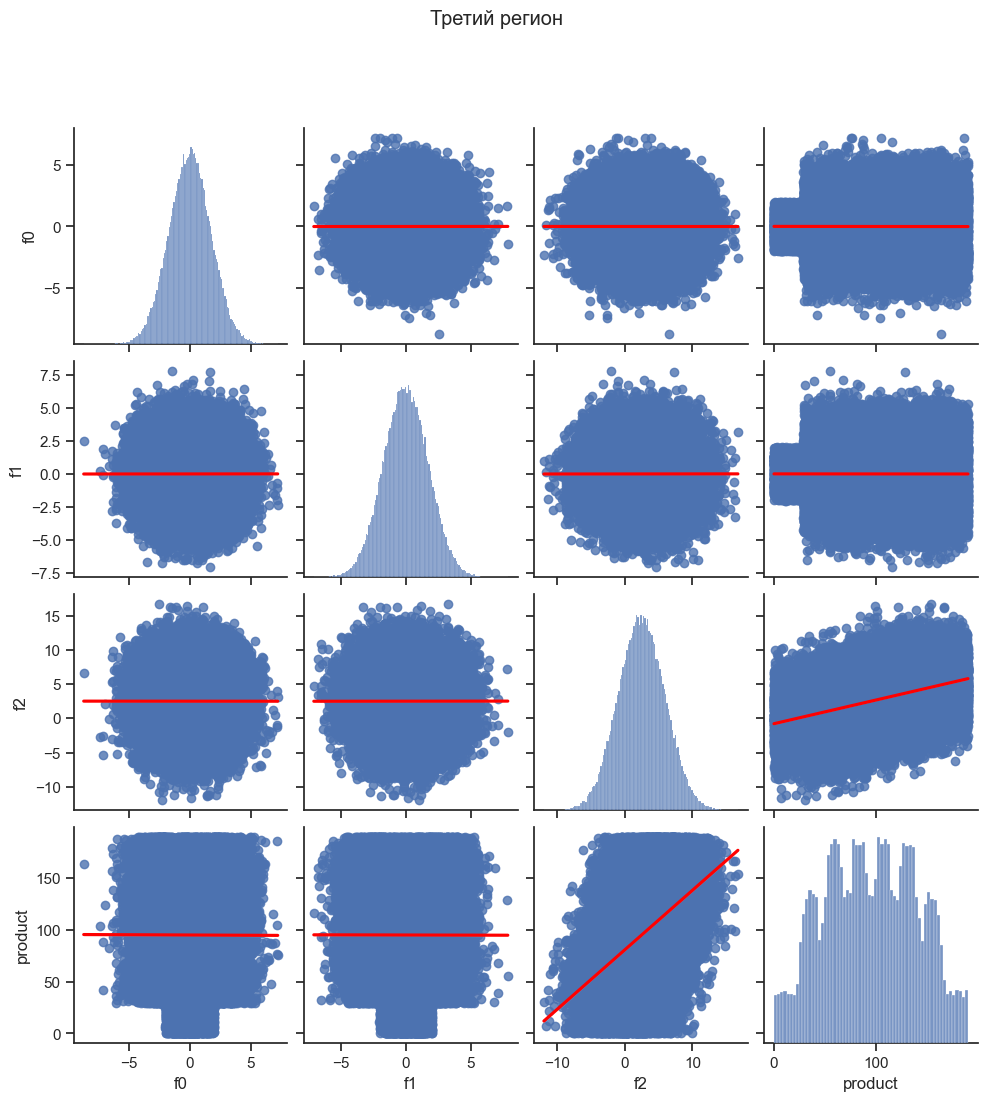

In [8]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(geo_2, kind="reg", plot_kws={'line_kws':{'color':'red'}})
g.fig.suptitle('Третий регион', y=1.1)
plt.show()

Для наглядности отобразил графики распределения с линейной регрессией для каждого из регионов.

## Обучение и проверка модели

Разобъем датасеты с данными по регионам на обучающую и валидационную выборки и обучим модели линейной регрессии

In [9]:
def train_test(geo):
    target = geo['product']
    features = geo.drop(['product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    pred_valid = model.predict(features_valid)
    pred_valid_series = pd.Series(pred_valid, index=features_valid.index)

    print("RMSE:", mean_squared_error(target_valid, pred_valid)**0.5.__round__(4))
    print("R2:", r2_score(target_valid, pred_valid).__round__(4))
    print("Средний запас предсказанного сырья:", pred_valid.mean().__round__(2))
    print("Средний запас сырья:", target.mean().__round__(2))
    
    return [pred_valid_series, target_valid]

print('Показатели первого региона:')
train_test(geo_0)
print('')
print('Показатели второго региона:')
train_test(geo_1)
print('')
print('Показатели третьего региона:')
train_test(geo_2)
print('')

Показатели первого региона:
RMSE: 37.5794217150813
R2: 0.2799
Средний запас предсказанного сырья: 92.59
Средний запас сырья: 92.5

Показатели второго региона:
RMSE: 0.8930992867756165
R2: 0.9996
Средний запас предсказанного сырья: 68.73
Средний запас сырья: 68.83

Показатели третьего региона:
RMSE: 40.02970873393434
R2: 0.2052
Средний запас предсказанного сырья: 94.97
Средний запас сырья: 95.0



Выводы: <p>
<b>Данные по первому региону: </b> <p>
 - Низкий коэффициент детерминации (R2) <p>
 - Высокая доля ошибок <p>

<b>Данные по второму региону: </b> <p>
 - Высокий коэффициент детерминации, что подразумевает малое количество ошибок в модели. <p>
 - Собственно, малое количество ошибок. <p>
 - Возможно, такие результаты связаны с более ранним выводом о втором регионе (касаемо корелляции между признаками) <p>

<b>Данные по третьему региону: </b> <p>
 - Низкий коэффициент детерминации (R2) <p>
 - Высокая доля ошибок <p>


## Подготовка к расчёту прибыли

Расчет минимального к-ва баррелей для безубыточности

In [10]:
budget = 10000000000
price_per_barrel = 450000
wells_to_pick = 200

barrels_min = budget/price_per_barrel/wells_to_pick

print('Минимальное количество баррелей для безубыточной разработки скважины:', barrels_min.__round__(2), 'тысяч баррелей')


Минимальное количество баррелей для безубыточной разработки скважины: 111.11 тысяч баррелей


Проверка соответствия запасов в регионах определенному нами минимуму

In [11]:
geo_list = [geo_0, geo_1, geo_2]

def geo_barrels_min(geo_list):
    n = 0
    for i in geo_list:
        n += 1
        if i['product'].mean() >= barrels_min:
            print('В', n, 'регионе', i['product'].mean().__round__(2), 'тыс. баррелей нефти. Он подходит для разработки')
        else:
            print('В', n, ' регионе', i['product'].mean().__round__(2), 'тыс. баррелей нефти. Он не подходит для разработки')

geo_barrels_min(geo_list)


В 1  регионе 92.5 тыс. баррелей нефти. Он не подходит для разработки
В 2  регионе 68.83 тыс. баррелей нефти. Он не подходит для разработки
В 3  регионе 95.0 тыс. баррелей нефти. Он не подходит для разработки


Выводы: <p>
На текущем этапе нельзя сказать, что хотя бы один из регионов подходит для разработки.

## Расчёт прибыли и рисков

Рассчитаем суммарную прибыль для 200 лучших скважин

In [12]:
def top_profits(top):
    revenue = top['product'].sum()*price_per_barrel
    profit = revenue - budget
    return [print(profit.round())]

print('Прибыль первого региона:')
top_profits(geo_0.sort_values(by='product', ascending=False).head(wells_to_pick))
print('')
print('Прибыль второго региона:')
top_profits(geo_1.sort_values(by='product', ascending=False).head(wells_to_pick))
print('')
print('Прибыль третьего региона:')
top_profits(geo_2.sort_values(by='product', ascending=False).head(wells_to_pick))
print('')

Прибыль первого региона:
6635036568.0

Прибыль второго региона:
2415086697.0

Прибыль третьего региона:
7059632928.0



In [13]:
def sum_well_profit(target, probs, count):
    best_probs = probs.sort_values(ascending=False)
    wells = target[best_probs.index][:count]
    profit = (wells.sum() * price_per_barrel - budget)
    return profit

In [25]:
state = np.random.RandomState(12345)
def boostrap(predictions, target):
    values = []
    loss = 0
    
    for i in range(1000):
        target_sample = target.sample(n = 500, replace=True, random_state=state)
        probs_sample = predictions[target_sample.index]
        profit = sum_well_profit(target_sample, probs_sample, wells_to_pick)
        values.append(profit)
     
    values = pd.Series(values)
    
    print("Средняя прибыль:", values.mean().__floor__())
    print("Доверительный интервал: от", values.quantile(0.025).__round__(2), "до", values.quantile(0.975).__round__(2))
    print("Риск убытков:", ((values < 0).mean() * 100))

In [26]:
l = 0
for i in geo_list:
    l += 1
    print('Результаты в', l, 'регионе')
    pred_valid, target_valid = train_test(i)
    boostrap(pred_valid, target_valid)
    print("")

Результаты в 1 регионе
RMSE: 37.5794217150813
R2: 0.2799
Средний запас предсказанного сырья: 92.59
Средний запас сырья: 92.5
Средняя прибыль: 425938526
Доверительный интервал: от -102090094.84 до 947976353.36
Риск убытков: 6.0

Результаты в 2 регионе
RMSE: 0.8930992867756165
R2: 0.9996
Средний запас предсказанного сырья: 68.73
Средний запас сырья: 68.83
Средняя прибыль: 518259493
Доверительный интервал: от 128123231.43 до 953612982.07
Риск убытков: 0.3

Результаты в 3 регионе
RMSE: 40.02970873393434
R2: 0.2052
Средний запас предсказанного сырья: 94.97
Средний запас сырья: 95.0
Средняя прибыль: 420194005
Доверительный интервал: от -115852609.16 до 989629939.84
Риск убытков: 6.2



<b>Общий вывод: </b> <p>
Регион к предложению разработки скважин - второй (geo_1). По крайней мере, для компании, не готовой к убыткам. Причины данного выбоpа: <p>
 - Минимальный среди всех трёх регионов риск убытков.
 - Максимальная средняя прибыль, которую можно извлечь.

В первом и третьем регионах риски кратно превышают таковые во втором в разы.